In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten, Dense, Dropout, Concatenate
from tensorflow.keras.applications import VGG16, DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback

# Define paths to train and test data
train_dir = '/content/drive/MyDrive/ImageDataset/Train'
test_dir = '/content/drive/MyDrive/ImageDataset/Test'

# Define image dimensions and batch size
img_width, img_height = 512, 512
batch_size = 32

# Create data generators for train and test data with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

# Function to duplicate the inputs for both models
def multiple_inputs_generator(generator):
    while True:
        data = next(generator)
        yield [data[0], data[0]], data[1]  # Yield inputs as [input1, input2] and output

# Create new generators
train_generator_multi = multiple_inputs_generator(train_generator)
test_generator_multi = multiple_inputs_generator(test_generator)

# Load the VGG16 and DenseNet121 pre-trained models
base_model1 = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
base_model2 = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Freeze the layers of the base models
for layer in base_model1.layers:
    layer.trainable = False

for layer in base_model2.layers:
    layer.trainable = False

# Add custom classification layers on top of the base models
x1 = Flatten()(base_model1.output)
x2 = Flatten()(base_model2.output)

# Concatenate the outputs of the two models
x = Concatenate()([x1, x2])

# Add a dense layer
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)  # Add dropout for regularization
output = Dense(1, activation='sigmoid')(x)

# Create the final model
model = Model(inputs=[base_model1.input, base_model2.input], outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks for model checkpoint and early stopping
model_checkpoint = ModelCheckpoint('ensemble.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=25, verbose=1)

# Define a custom callback to stop training when accuracy meets 94%
class CustomEarlyStopping(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}
        if logs.get('val_accuracy') >= 0.94:
            print("Reached 94% validation accuracy. Stopping training.")
            self.model.stop_training = True

custom_early_stopping = CustomEarlyStopping()

# Train the model with the custom callback
history = model.fit(
    train_generator_multi,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=30,
    validation_data=test_generator_multi,
    validation_steps=test_generator.samples // batch_size,
    callbacks=[model_checkpoint, early_stopping, custom_early_stopping]
)

# Evaluate the model on test data

test_loss, test_accuracy = model.evaluate(test_generator_multi, steps=test_generator.samples // batch_size)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Found 1931 images belonging to 2 classes.
Found 829 images belonging to 2 classes.
29084464/29084464 [==============================] - 0s 0us/step
Epoch 1/30
60/60 [==============================] - ETA: 0s - loss: 3.0174 - accuracy: 0.5411
Epoch 1: val_accuracy improved from -inf to 0.65625, saving model to ensemble.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


60/60 [==============================] - 927s 15s/step - loss: 3.0174 - accuracy: 0.5411 - val_loss: 0.6490 - val_accuracy: 0.6562
Epoch 2/30
60/60 [==============================] - ETA: 0s - loss: 0.6733 - accuracy: 0.5698
Epoch 2: val_accuracy did not improve from 0.65625
60/60 [==============================] - 209s 3s/step - loss: 0.6733 - accuracy: 0.5698 - val_loss: 0.6329 - val_accuracy: 0.6550
Epoch 3/30
60/60 [==============================] - ETA: 0s - loss: 0.6803 - accuracy: 0.5582
Epoch 3: val_accuracy improved from 0.65625 to 0.66123, saving model to ensemble.h5
60/60 [==============================] - 250s 4s/step - loss: 0.6803 - accuracy: 0.5582 - val_loss: 0.6406 - val_accuracy: 0.6612
Epoch 4/30
60/60 [==============================] - ETA: 0s - loss: 0.6619 - accuracy: 0.5824
Epoch 4: val_accuracy did not improve from 0.66123
60/60 [==============================] - 193s 3s/step - loss: 0.6619 - accuracy: 0.5824 - val_loss: 0.6250 - val_accuracy: 0.6085
Epoch 5/30


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tensorflow.keras.models import load_model

# Assuming you have a trained model stored in the variable 'model'
# Save the model to an HDF5 file
model.save("model.h5")


In [ ]:
import os

# Define the folder name where you want to save your model
folder_name = 'models'

# Define the path to your Google Drive folder
drive_folder_path = '/content/drive/MyDrive/'

# Create the full path including the folder name
model_path = os.path.join(drive_folder_path, folder_name)

# Check if the folder exists, if not, create it
if not os.path.exists(model_path):
    os.makedirs(model_path)

print("Model path:", model_path)


Model path: /content/drive/MyDrive/models


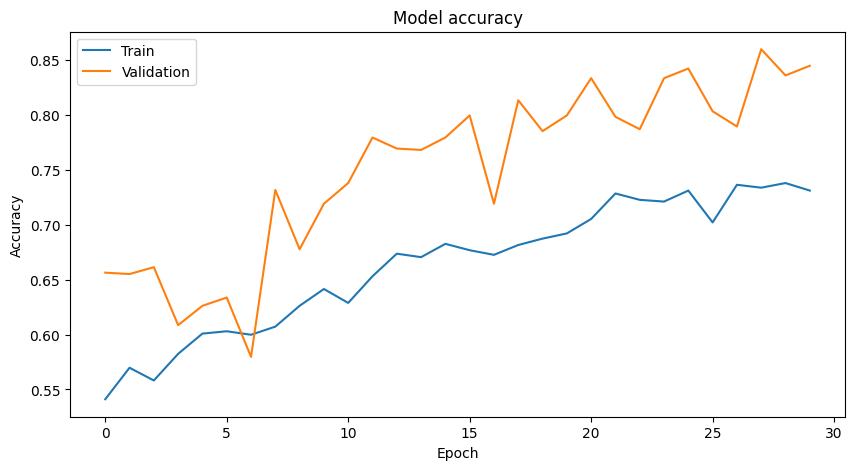

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have the history of your model training saved in a variable named 'history'
plot_accuracy(history)

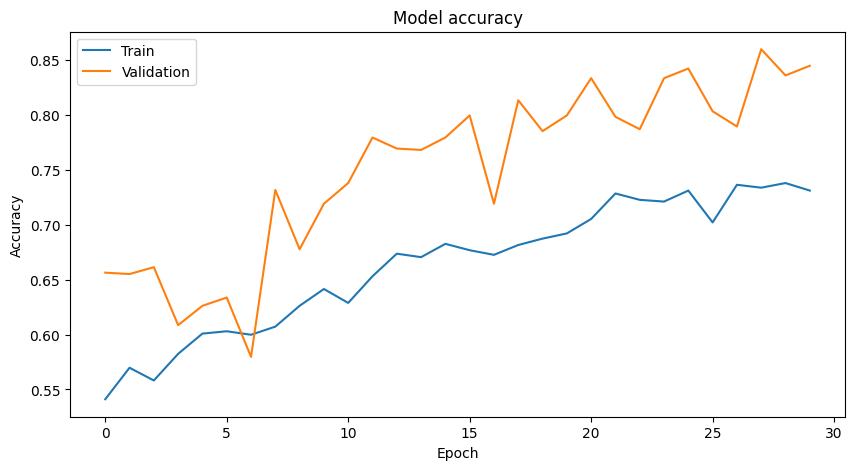

In [ ]:
def plot_accuracy(history):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# Assuming you have the history of your model training saved in a variable named 'history'
plot_accuracy(history)

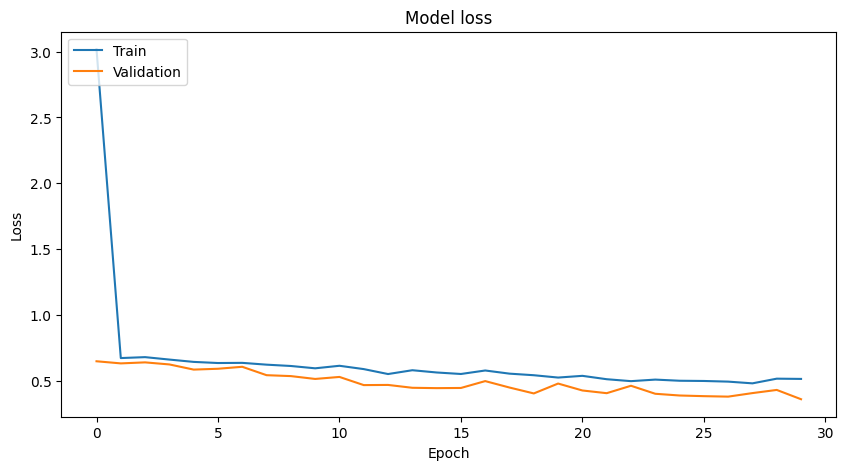

In [ ]:
import matplotlib.pyplot as plt

def plot_loss(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# Assuming you have the history of your model training saved in a variable named 'history'
plot_loss(history)

In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score

# Load your trained model
model = load_model('/content/ensemble.h5')

# Print the model summary
model.summary()

test_dir = '/content/drive/MyDrive/ImageDataset/Test'
img_width, img_height = 224, 224  # Adjust these dimensions according to your model's input requirements
batch_size = 32  # Adjust batch size as needed

# Define image data generator
test_datagen = ImageDataGenerator(rescale=1./255)

# Load images from

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 518, 518, 3)          0         ['input_2[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 256, 256, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 256, 256, 64)         256       ['conv1/conv[0][0]']      